* Import librairies

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchsummary import summary

* Download Multi-class Weather Dataset from kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pratik2901/multiclass-weather-dataset
!unzip 'multiclass-weather-dataset.zip'
!kaggle datasets download -d pratik2901/multiclass-weather-dataset
%cd "/content/Multi-class Weather Dataset"

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 89.0M/91.4M [00:05<00:00, 20.3MB/s]
100% 91.4M/91.4M [00:05<00:00, 18.8MB/s]
Archive:  multiclass-weather-dataset.zip
  inflating: Multi-class Weather Dataset/Cloudy/cloudy1.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy10.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy100.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy101.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy102.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy103.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy104.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy105.jpg  
  inflating: Multi-class Weather Dataset/Cloudy/cloudy106.jpg  
  inflating: Multi-class Weather D

* Load all images from dataset


In [ ]:
dataset = torchvision.datasets.ImageFolder(
        root = "/content/Multi-class Weather Dataset", # data_path is path to directory
        transform = None,
)

print(dataset)

* Divide dataset into train (70%) and test (30%) subsets

In [ ]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(len(train_dataset), "train samples and", len(test_dataset), "test samples")

* Define transformations on train and tests subsets

In [ ]:

IMAGE_SIZE = 128

train_transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)), # resize image to 128 x 128
        transforms.RandomRotation(10), # make a random rotation between 0 and 10 degrees
        transforms.RandomResizedCrop(128), # crop the image in a local region and resize it to 128
        transforms.RandomHorizontalFlip(), # make horizontal flip
        transforms.ToTensor(), # normal pixels in [0..1]
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
    ]
)

train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform


* Create DataLoader object for train and test subsets

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 32,
                                           shuffle = True
)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = 32,
                                          shuffle = False
)

for batch_num, (images, targets) in enumerate(train_loader):
  print("Batch image size", images.shape, "---- Batch label size", targets.shape)

Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Batch label size torch.Size([32])
Batch image size torch.Size([32, 3, 128, 128]) ---- Ba

* Plot an example of originl and augmented image

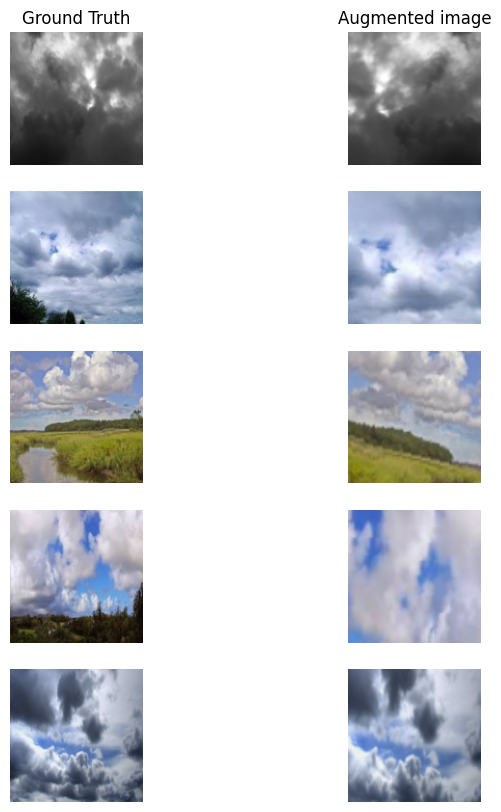

In [ ]:
import matplotlib.pyplot as plt

# Define a DataLoader without transform
load_batch = torch.utils.data.DataLoader( dataset = dataset,
                                         batch_size = 5,
)

# Load a bach of 5 images
gt_img, _ = next(iter(load_batch))

# show 5 images and their transformations
idx = 0
f, axarr = plt.subplots(5, 2, figsize=(8, 10))
axarr[0, 0].set_title("Ground Truth")
axarr[0, 1].set_title("Augmented image")

for r in range(0, 5):
  # plot ground truth image
  axarr[r, 0].imshow(transforms.ToPILImage()(gt_img[idx].squeeze()))
  axarr[r, 0].set_axis_off()

  # plot augmented image
  new_img = train_transform(transforms.ToPILImage()(gt_img[idx].squeeze()))
  axarr[r, 1].imshow(transforms.ToPILImage()(new_img.squeeze()))
  axarr[r, 1].set_axis_off()
  idx+=1

* Implement CNN model:
  - Block 1 :
    * Conv2D : 32 filters, size (3, 3), stride = (1, 1)
    * Activation layer : ReLU
    * MaxPooling2D : pool size = (2, 2), stride = (2, 2)
  - Block 2 :
    * Conv2D : 64 filters, size = (3, 3), stride = (1, 1)
    * Activation layer : ReLU
    * MaxPooling2D : pool size = (2, 2), stride = (2, 2)
  - Flatten
  - Linear : 128 neurons
  - Activation : ReLU
  - Linear : 4 neurons
  - Activation layer : Softmax

In [ ]:
class CNN (nn.Module):

  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=(1,1)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),
    nn.Linear(in_features=64*30*30, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=4),
    nn.Softmax(dim=1),
    )

  def forward (self, x):
    out = self.layers(x)
    return out

* Create an instance of CNN and turn it on CUDA device

In [ ]:
# create an instance of class CNN
cnn = CNN()

# test if cuda is available
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

cnn = cnn.to(device)

* Show the model summary

In [ ]:
summary(cnn, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             896
              ReLU-2         [-1, 32, 126, 126]               0
         MaxPool2d-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 61, 61]          18,496
              ReLU-5           [-1, 64, 61, 61]               0
         MaxPool2d-6           [-1, 64, 30, 30]               0
           Flatten-7                [-1, 57600]               0
            Linear-8                  [-1, 128]       7,372,928
              ReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 4]             516
          Softmax-11                    [-1, 4]               0
Total params: 7,392,836
Trainable params: 7,392,836
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forw

* Define hyper-parameters (Loss function and optimizer)

In [ ]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# optimizer Adam
optimizer = torch.optim.Adam(params = cnn.parameters(), lr=1e-4, )

* Run the training Loop

In [ ]:
epochs = 20

# set cnn model in train mode
cnn.train()

for epoch in range(epochs):

  # define a list to store the losses of the different batches
  losses = []

  # iter over patches
  for batch_num, (train_images, targets_images) in enumerate(train_loader):

    # initialize the optimizer (Zero the gradients)
    optimizer.zero_grad()

    # turn train_images and train_targets on CUDA device if available
    images = images.to(device)
    targets = targets.to(device)

    # Propagate the images and return the predicted output (Perform forward pass)
    output = cnn(images)

    # calculate the loss between actual and predicted outputs (Compute loss)
    loss = loss_function(output, targets)
    losses.append(loss.item())

    # Prpagate the gradient of the loss in reverse (Perform backward pass)
    loss.backward()

    # update the model parameters (Perform optimization)
    optimizer.step()

      #if batch_num % 4 == 0:
          # print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
  print('Epoch %d -- Loss %6.4f' % (epoch, sum(losses)/len(losses)))

# Process is complete.
print('Training process has finished.')

* Save the trained model

In [ ]:
torch.save(cnn, 'cnn_model_aug.pth')

* Load the model and run evaluation

In [ ]:
# load model saved in "mlp_model.pth"
cnn_model = torch.load('cnn_model_aug.pth')

# turn cnn_model to CUDA device if available
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

cnn_model.to(device)

# initialize evaluation metrics
total_samples = len(test_loader.dataset)
correct_samples = 0
total_loss = 0

# set the model in evaluation mode
cnn_model.eval()

# iter over batches
for num_batch, (test_images, test_targets) in enumerate(test_loader):
  # extract images and targets from test_data (Get inputs)
  test_images = test_images.to(device)
  test_targets = test_targets.to(device)

  # calculate logits
  outputs = cnn_model(test_images)

  # calculate loss
  loss = loss_function(outputs, test_targets)
  total_loss += loss.item()

  # predict classes from outputs
  pred_targets = outputs.argmax(dim=1)

  # calculate correct predictions
  nb_correct = pred_targets.eq(test_targets).sum()
  correct_samples += nb_correct

avg_loss = total_loss / len(test_loader)
val_accuracy = (correct_samples / total_samples)

print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
        '  val_accuracy:' + '{:.4f}'.format(val_accuracy) + '\n')